In [ ]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 13.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, DDIMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
"""
  Import datasets and create dataloaders
"""

# import dataset
mnist = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
fashion_mnist = torchvision.datasets.FashionMNIST(root="fashion_mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
cifar10 = torchvision.datasets.CIFAR10(root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor())
# create dataloaders
train_dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 392401382.18it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35254858.51it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 177348738.25it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3203923.44it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 26421880/26421880 [00:03<00:00, 8671211.63it/s] 


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144433.57it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2736876.57it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8298338.58it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 170498071/170498071 [00:13<00:00, 12888546.44it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10/


In [ ]:
"""
  Define a Class-conditioned UNet model
"""
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4, sample_size=28, c_in=1, c_out=1):
    super().__init__()
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    self.model = UNet2DModel(
        sample_size=sample_size,          
        in_channels=c_in + class_emb_size, 
        out_channels=c_out,           
        layers_per_block=2,      
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",       
            "AttnDownBlock2D",    
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      
            "UpBlock2D",         
          ),
    )

  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape
    class_cond = self.class_emb(class_labels) 
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    net_input = torch.cat((x, class_cond), 1) 
    return self.model(net_input, t).sample

In [ ]:
"""
  Define a Diffusion model
"""
class Diffuser():
  def __init__(self, dataloader, num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2', num_classes=10, class_emb_size=4, sample_size=28, c_in=1, c_out=1):
    self.num_classes = num_classes
    self.train_dataloader = dataloader
    self.num_train_timesteps = num_train_timesteps
    self.net = ClassConditionedUnet(num_classes=num_classes, class_emb_size=class_emb_size, sample_size=sample_size, c_in=c_in, c_out=c_out).to(device)
    self.noise_scheduler = DDPMScheduler(num_train_timesteps=self.num_train_timesteps, beta_schedule=beta_schedule)
    self.sample_size = sample_size
    self.channels = c_in
  
  def train(self, n_epochs=5, lr=1e-3):
    self.loss_fn = nn.MSELoss()
    self.opt = torch.optim.Adam(self.net.parameters(), lr)
    self.losses = []

    for epoch in range(n_epochs):
      for x,y in tqdm(self.train_dataloader):
        x = x.to(device)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, self.num_train_timesteps-1, (x.shape[0],)).long().to(device)
        noisy_x = self.noise_scheduler.add_noise(x,noise,timesteps)

        pred = self.net(noisy_x, timesteps, y)
        loss = self.loss_fn(pred, noise)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        self.losses.append(loss.item())
  
  def sample(self):
    x = torch.randn(80, self.channels, self.sample_size, self.sample_size).to(device)
    y = torch.tensor([[i]*8 for i in range(self.num_classes)]).flatten().to(device)

    for i,t in tqdm(enumerate(self.noise_scheduler.timesteps)):
      with torch.no_grad():
        residual = self.net(x,t,y)

      x = self.noise_scheduler.step(residual, t, x).prev_sample
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
    return x

In [ ]:
"""
Generate images
"""

diffuser = Diffuser(dataloader=train_dataloader,
                    num_train_timesteps=1000, 
                    beta_schedule='squaredcos_cap_v2', 
                    num_classes=10, 
                    class_emb_size=4, 
                    sample_size=28, 
                    c_in=1, 
                    c_out=1)
diffuser.train(n_epochs=150, lr=1e-4)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

0it [00:00, ?it/s]

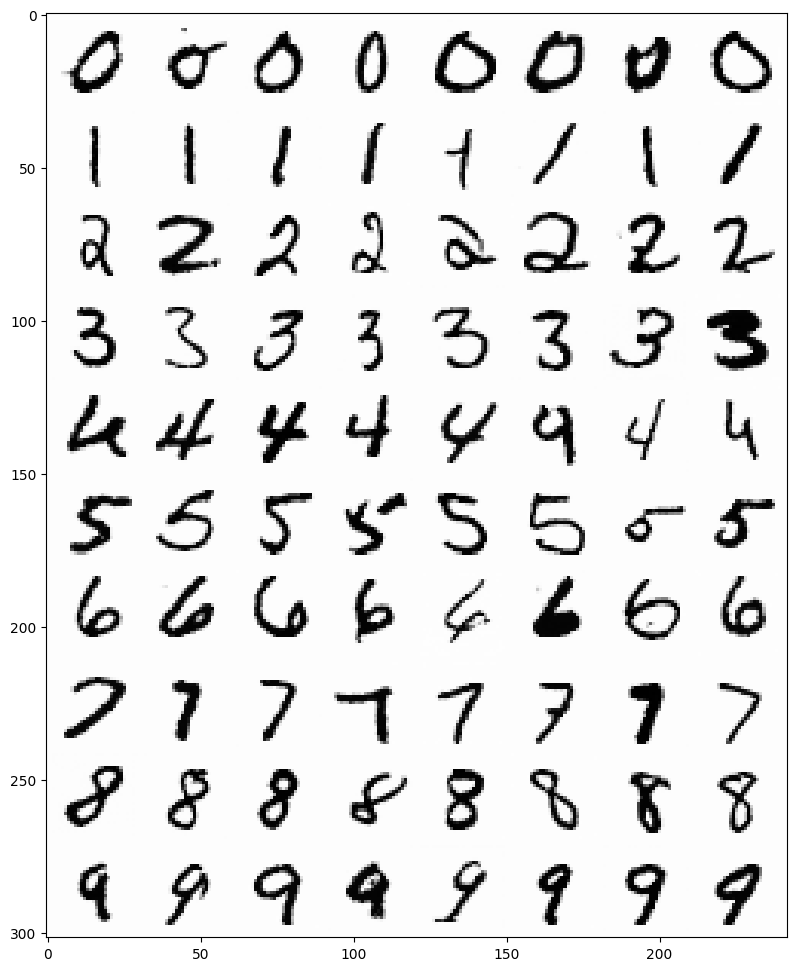

In [ ]:
#diffuser.noise_scheduler.set_timesteps(1000)
samples = diffuser.sample()

In [ ]:
samples.shape

torch.Size([80, 1, 28, 28])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

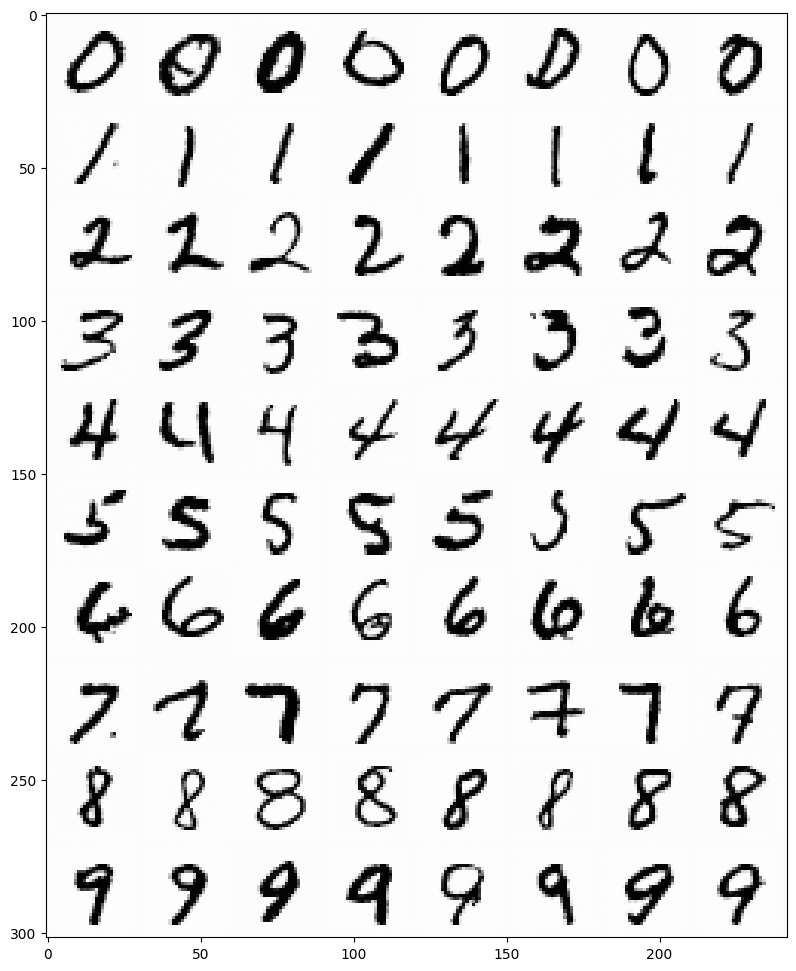

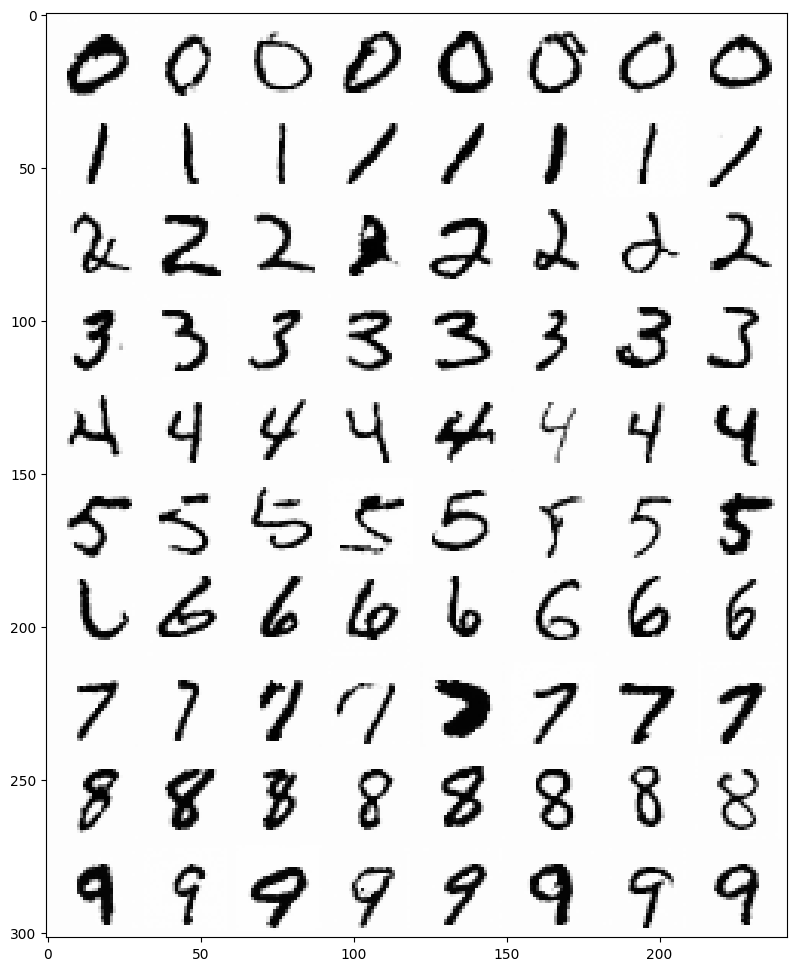

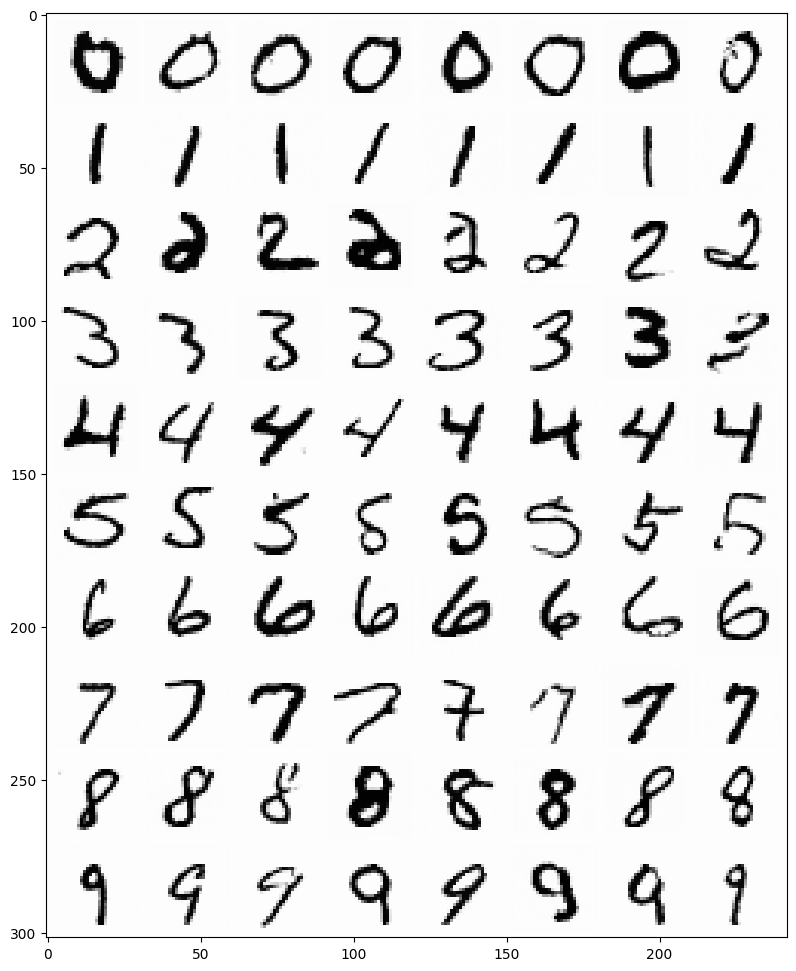

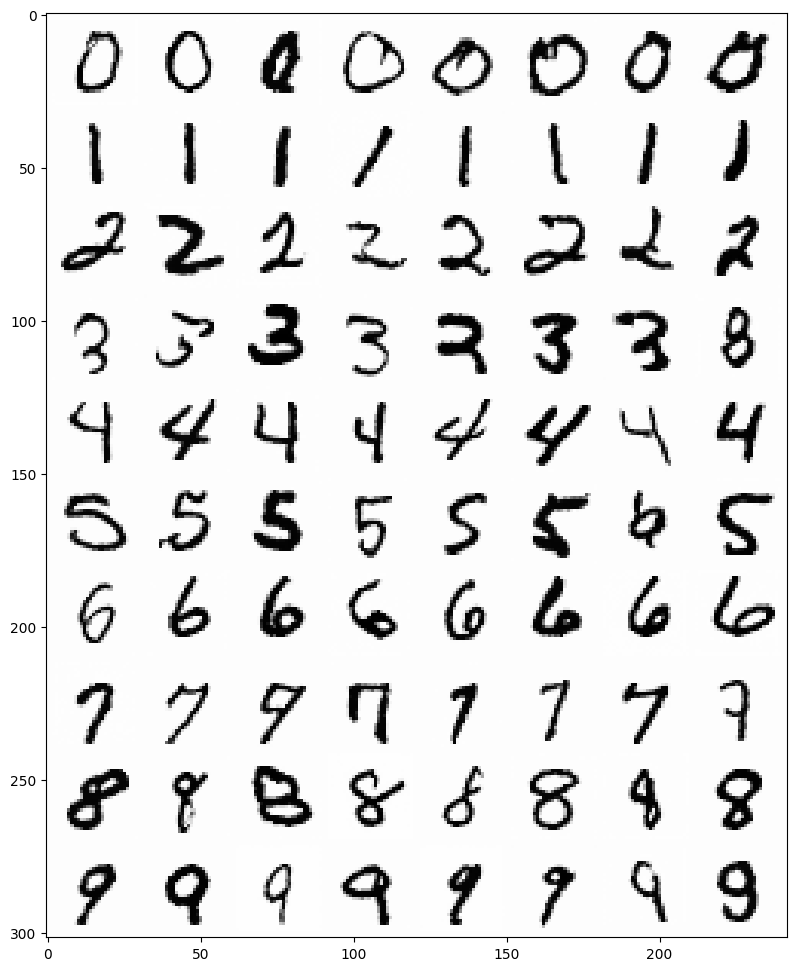

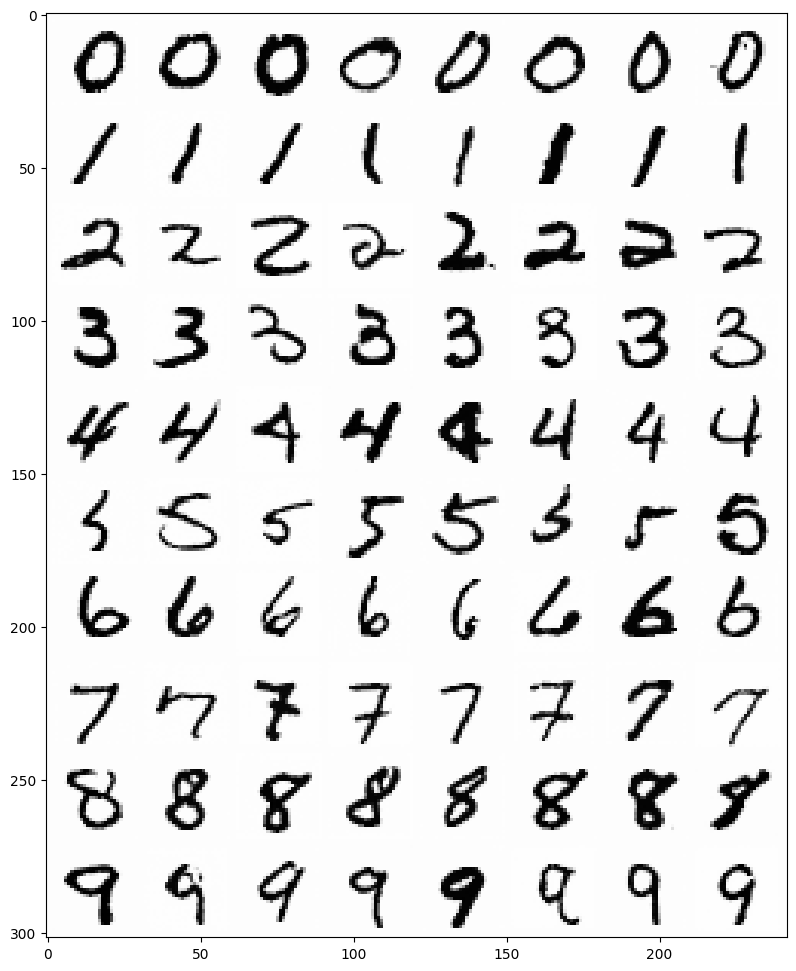

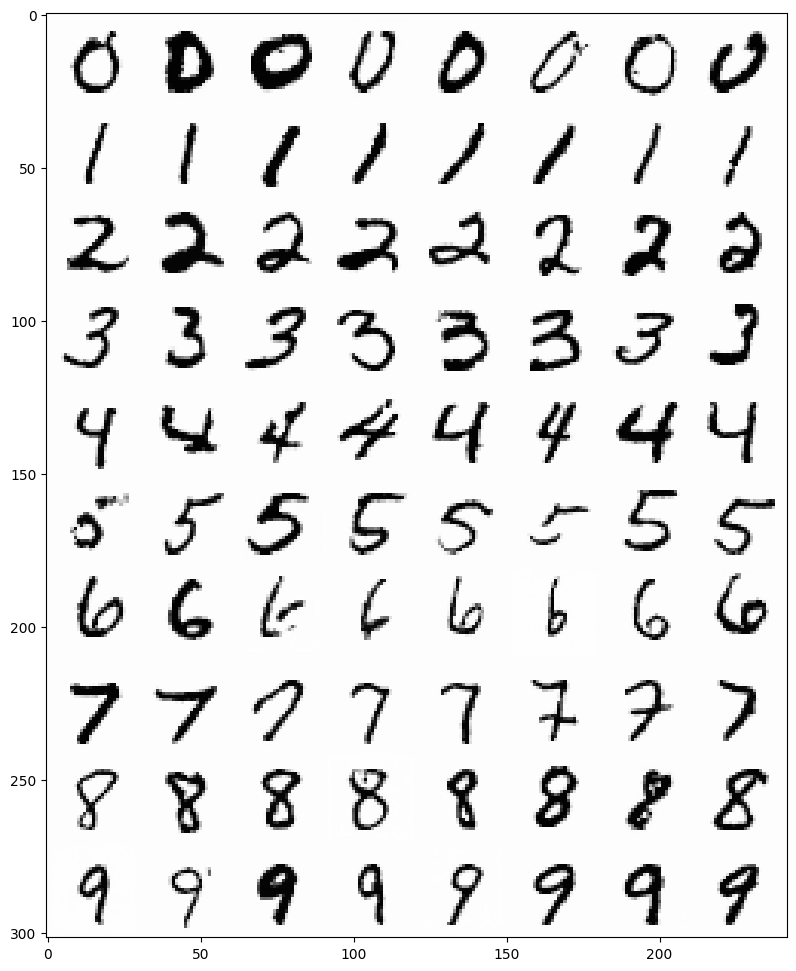

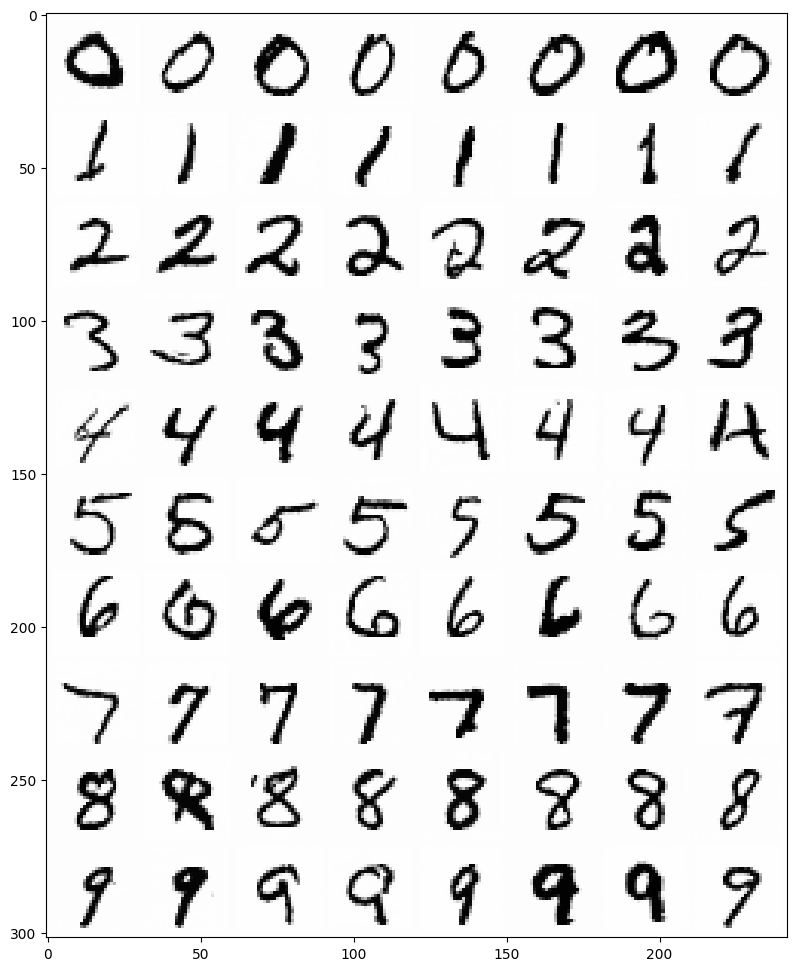

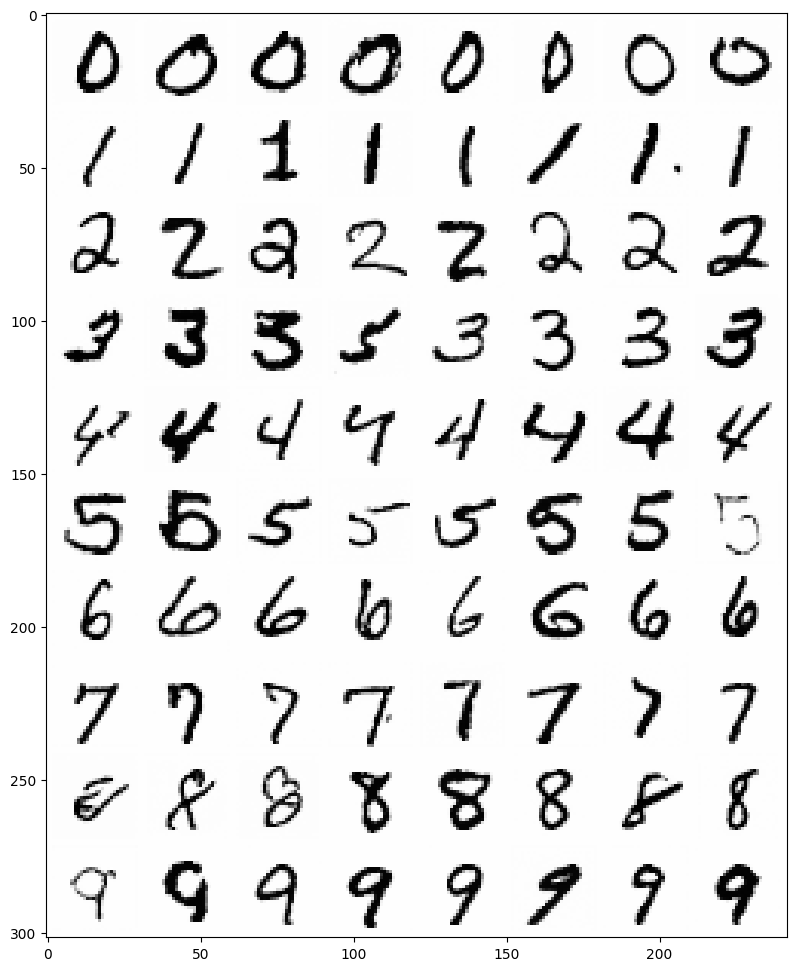

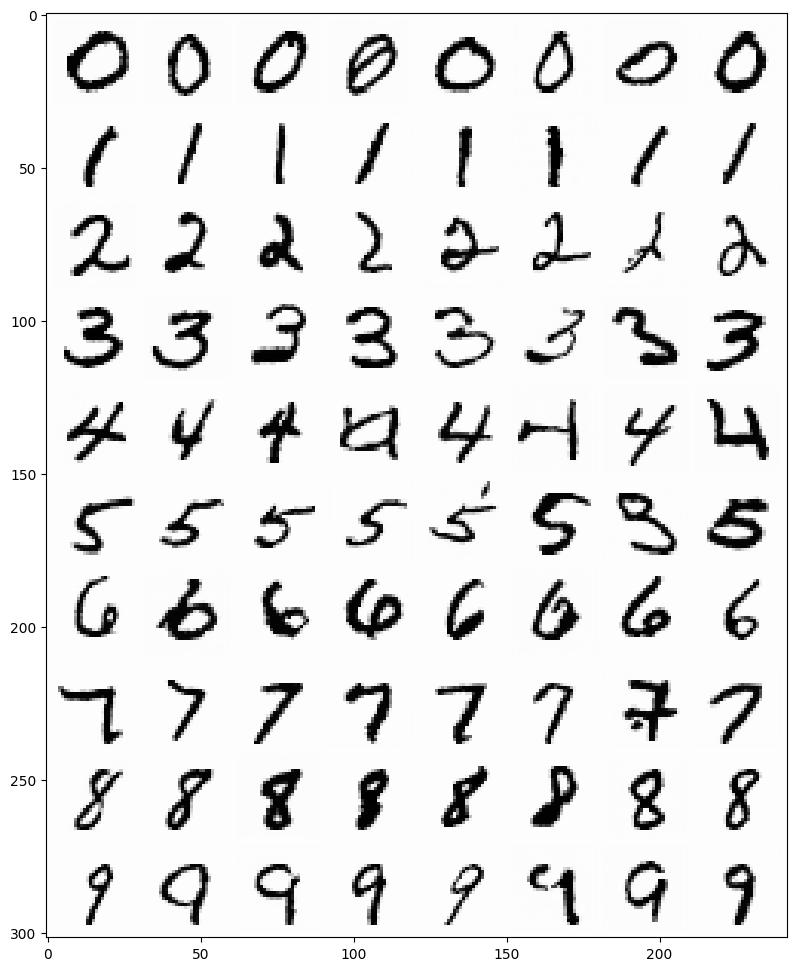

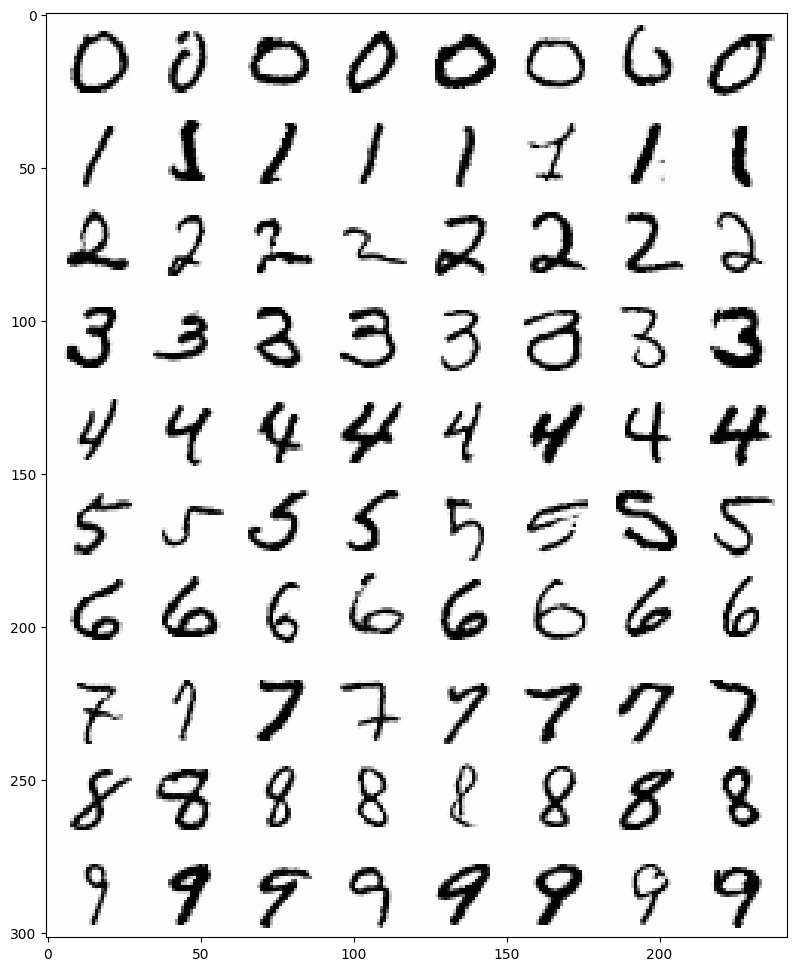

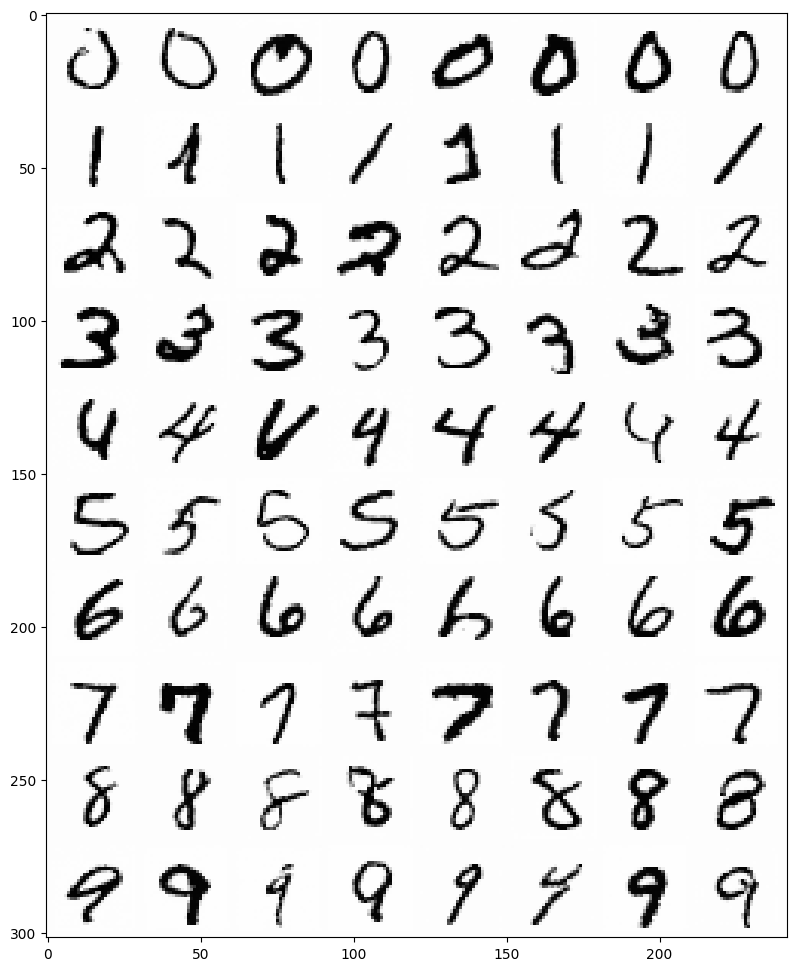

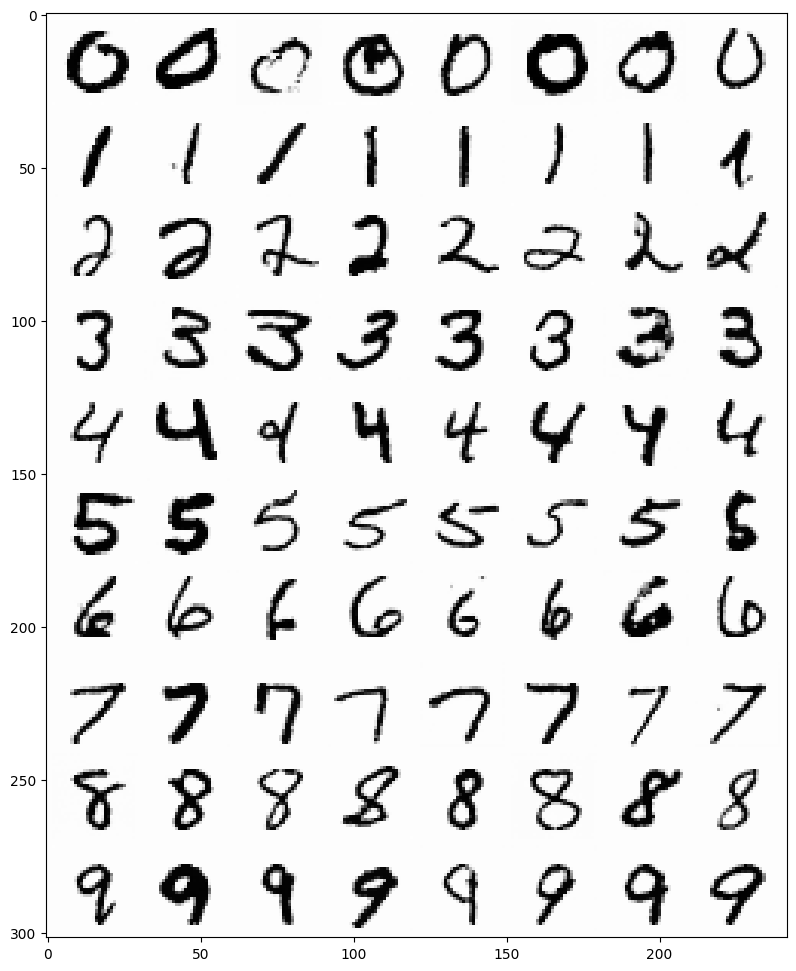

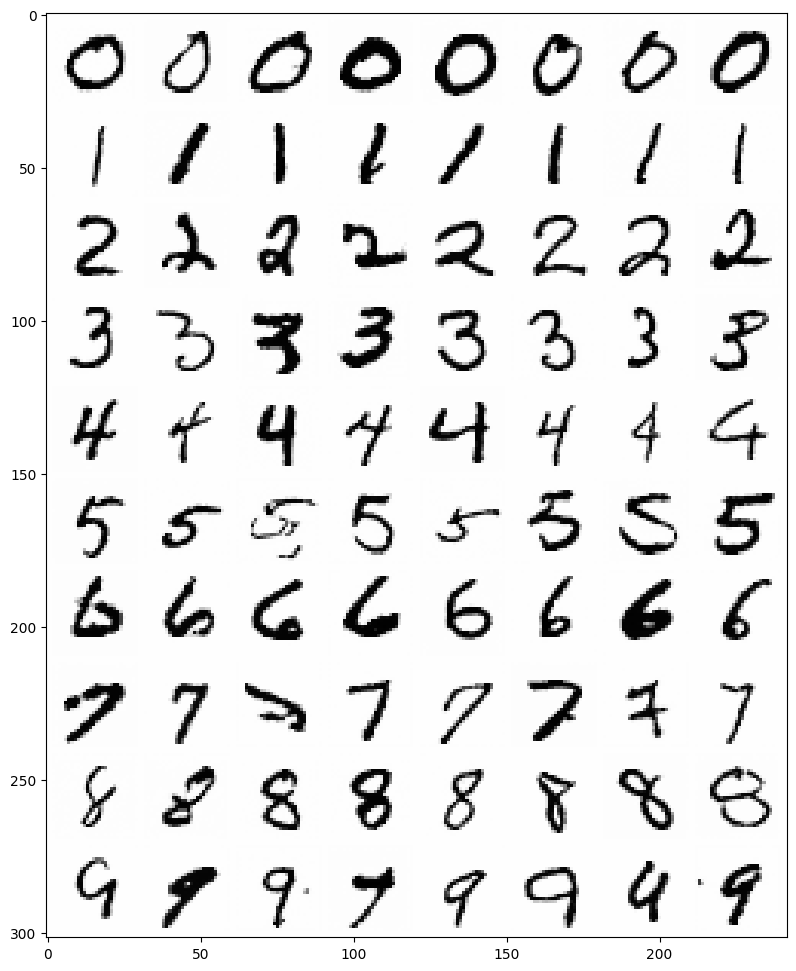

In [ ]:
tests = []

for _ in range(13):
  samples = diffuser.sample()
  tests.append(samples)

In [ ]:
for _ in range(50):
  samples = diffuser.sample()
  tests.append(samples)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(tests, 'tests_ddpm.pt')

In [ ]:
from google.colab import files
files.download('tests_ddpm.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x = torch.load('tests_ddpm.pt')

In [ ]:
len(x)

63

In [ ]:
mnist = torchvision.datasets.MNIST(root="mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
mnist

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist/
    Split: Test
    StandardTransform
Transform: ToTensor()

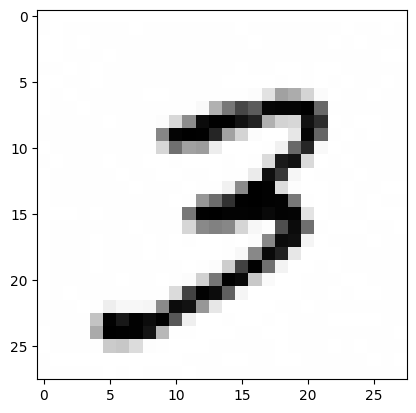

In [ ]:
plt.imshow(x[0][24].permute(1,2,0).cpu(),cmap='Greys')

In [ ]:
annotated_tests = []

for batch in tests:
  for i in range(len(batch)):
    cur_num = int(i/8)
    annotated_tests.append((batch[i].cpu(), cur_num))

In [ ]:
torch.save(annotated_tests, 'annotated_tests_ddpm.pt')

In [ ]:
files.download('annotated_tests_ddpm.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mnist_extra = mnist+annotated_tests

In [ ]:
len(mnist_extra)

15040

In [ ]:
type(mnist_extra)

torch.utils.data.dataset.ConcatDataset

In [ ]:
x = torch.load('annotated_tests.pt')

In [ ]:
len(x)

5040

In [ ]:
x_80 = x[320:400]
len(x_80)

80

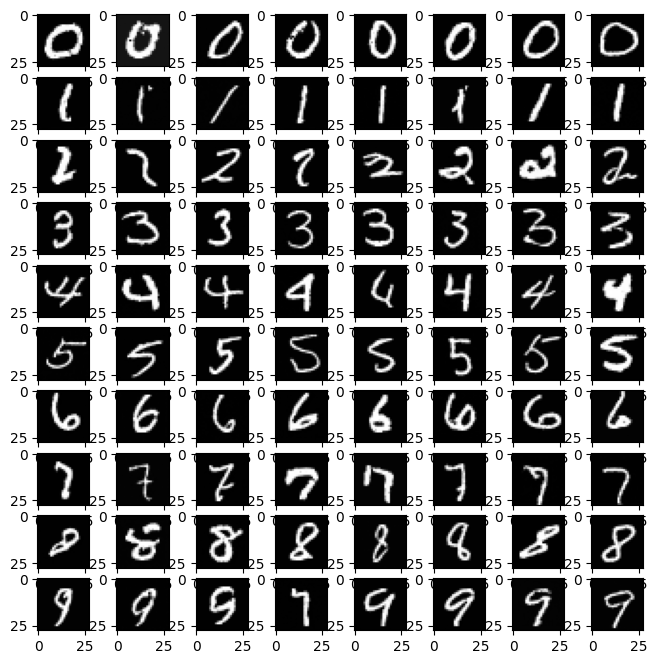

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 8
rows = 10
for i in range(1,81):
  img = torchvision.utils.make_grid(x_80[i-1][0])[0]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
x_2 = torch.load('annotated_tests_ddim.pt')

In [ ]:
x_80 = x_2[80:160]

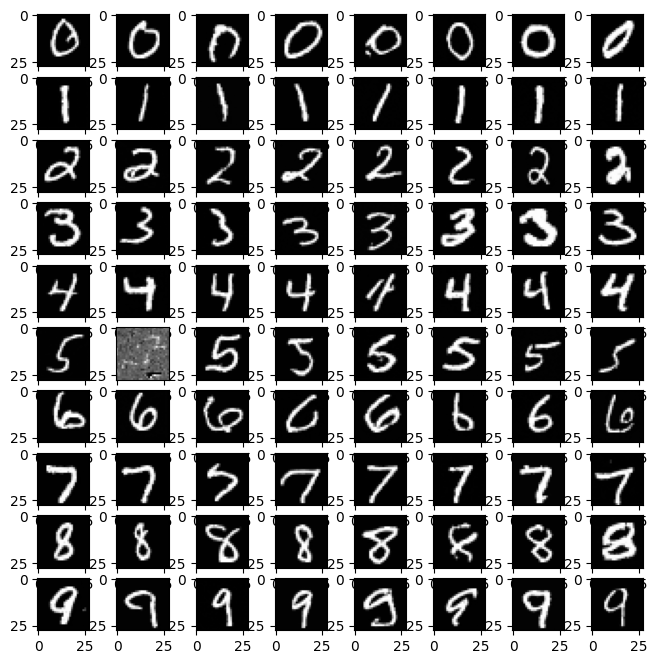

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 8
rows = 10
for i in range(1,81):
  img = torchvision.utils.make_grid(x_80[i-1][0])[0]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img,cmap='gray')
plt.show()